<a href="https://colab.research.google.com/github/Piramu-Mahalingam/DS-Course-Assignment-1/blob/main/Piramu%20M%20Assignment%20RNN-NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Piramu M Assignment NLP-RNN
#a)	Explain the architecture of LSTM and GRU in detail. What were the shortcomings of RNN that were resolved by LSTM and GRU

1. Background: RNN and its Shortcomings

Recurrent Neural Networks (RNNs) are designed to handle sequential data by maintaining a hidden state that captures information from previous time steps.

Equation (vanilla RNN):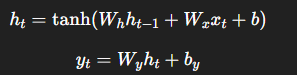

Shortcomings of RNNs:

Vanishing Gradient Problem – When training with backpropagation through time (BPTT), gradients shrink exponentially, making it hard to learn long-term dependencies.

Exploding Gradient Problem – Sometimes gradients blow up, causing unstable training.

Short-term Memory – RNNs mostly capture short dependencies but fail for long sequences (e.g., remembering context 50+ steps earlier).

Slow Training – Difficulty in optimization due to gradient issues.

LSTM Architecture (Long Short-Term Memory)

An LSTM cell introduces a cell state and three gates to regulate information.

Key Components:

Cell State (Ct) Acts like a conveyor belt, carrying long-term information with minimal modification.

Hidden State (ht) Used for current step output.

Gates (sigmoid layers that output 0–1, controlling information flow):

Forget Gate (ft) → Decides what to discard.

Input Gate (it) → Decides what new info to store.

Output Gate (ot) → Decides what to output.

low:

Forget Gate: drops irrelevant info.

Input Gate + Candidate: adds new relevant info.

Output Gate: decides the final output.

This structure preserves long-term dependencies and avoids vanishing gradients.

GRU Architecture (Gated Recurrent Unit)

GRU is a simplified version of LSTM – it merges cell state & hidden state into one (ht) and uses only two gates.

Key Components:

Update Gate (zt) – Combines role of input + forget gate.

Reset Gate (rt) – Decides how much past info to forget.

low:

Reset Gate: decides how much past to ignore.

Update Gate: decides how much of new vs old info to keep.

GRU is computationally lighter and trains faster than LSTM while still solving RNN shortcomings.

#b)	Use the emotions detection dataset from below Kaggle link and create an end-to-end project on Jupyter/Colab to predict the person’s emotions.

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data


In [4]:
#i.	Download the dataset from above link and load it in your Python environment
import zipfile, os

# Path to uploaded file
zip_path = "/content/archive.zip"
extract_dir = "/content/emotions_dataset"

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List extracted files
os.listdir(extract_dir)


['test.txt', 'train.txt', 'val.txt']

In [5]:
#i.	Download the dataset from above link and load it in your Python environment
import pandas as pd

# Define paths
train_path = os.path.join(extract_dir, "train.txt")
val_path = os.path.join(extract_dir, "val.txt")
test_path = os.path.join(extract_dir, "test.txt")

# Load function
def load_emotions_file(path):
    return pd.read_csv(path, sep=";", header=None, names=["text", "emotion"], encoding="utf-8")

# Load datasets
train_df = load_emotions_file(train_path)
val_df = load_emotions_file(val_path)
test_df = load_emotions_file(test_path)

(train_df.shape, val_df.shape, test_df.shape)


((16000, 2), (2000, 2), (2000, 2))

In [7]:
#ii.    Perform the data cleaning like stopwords removal, lowercase, stemming, lemmatization etc.
import re
import nltk

# Download resources (only once, safe check)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Added this line to download the missing resource


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, special chars
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Stemming + Lemmatization
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# Apply cleaning to train, val, and test datasets
train_df["clean_text"] = train_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

# Show samples
train_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,emotion,clean_text
0,i didnt feel humiliated,sadness,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,feel grouchi


In [8]:
#iii.	Perform feature engineering and word embedding techniques like TFIDF, word2Vec, Bag of words etc
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=5000)  # choose vocabulary size
X_train_bow = bow_vectorizer.fit_transform(train_df["clean_text"])
X_val_bow   = bow_vectorizer.transform(val_df["clean_text"])
X_test_bow  = bow_vectorizer.transform(test_df["clean_text"])


In [9]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["clean_text"])
X_val_tfidf   = tfidf_vectorizer.transform(val_df["clean_text"])
X_test_tfidf  = tfidf_vectorizer.transform(test_df["clean_text"])


In [10]:
#Word2vec
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Train Word2Vec on our training data (can also load pre-trained embeddings)
sentences = [word_tokenize(text) for text in train_df["clean_text"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to average word embeddings for a document
def document_vector(doc):
    words = [w for w in word_tokenize(doc) if w in w2v_model.wv]
    if not words:
        return np.zeros(100)
    return np.mean(w2v_model.wv[words], axis=0)

# Apply to train/val/test
X_train_w2v = np.array([document_vector(text) for text in train_df["clean_text"]])
X_val_w2v   = np.array([document_vector(text) for text in val_df["clean_text"]])
X_test_w2v  = np.array([document_vector(text) for text in test_df["clean_text"]])


In [13]:
#iv.    Use the ML algorithms like logistic reg, DT, random forest etc. to predict the emotions.
#Encode the target labels
from sklearn.preprocessing import LabelEncoder

# Convert emotion labels to numeric
le = LabelEncoder()
y_train = le.fit_transform(train_df["emotion"])
y_val   = le.transform(val_df["emotion"])
y_test  = le.transform(test_df["emotion"])


#Train baseline ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store results
results = {}

def evaluate_model(model, X_train, y_train, X_val, y_val, feature_name, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[f"{model_name} ({feature_name})"] = acc
    print(f"\n{model_name} with {feature_name} features:")
    print("Accuracy:", acc)
    print(classification_report(y_val, y_pred, target_names=le.classes_))
    return model

# Logistic Regression with TF-IDF
lr_tfidf = evaluate_model(
    LogisticRegression(max_iter=200),
    X_train_tfidf, y_train, X_val_tfidf, y_val,
    "TF-IDF", "Logistic Regression"
)

# Decision Tree with TF-IDF
dt_tfidf = evaluate_model(
    DecisionTreeClassifier(),
    X_train_tfidf, y_train, X_val_tfidf, y_val,
    "TF-IDF", "Decision Tree"
)

# Random Forest with TF-IDF
rf_tfidf = evaluate_model(
    RandomForestClassifier(n_estimators=100),
    X_train_tfidf, y_train, X_val_tfidf, y_val,
    "TF-IDF", "Random Forest"
)



Logistic Regression with TF-IDF features:
Accuracy: 0.8705
              precision    recall  f1-score   support

       anger       0.90      0.84      0.87       275
        fear       0.88      0.78      0.83       212
         joy       0.86      0.94      0.90       704
        love       0.86      0.65      0.74       178
     sadness       0.88      0.93      0.90       550
    surprise       0.86      0.63      0.73        81

    accuracy                           0.87      2000
   macro avg       0.87      0.80      0.83      2000
weighted avg       0.87      0.87      0.87      2000


Decision Tree with TF-IDF features:
Accuracy: 0.8235
              precision    recall  f1-score   support

       anger       0.82      0.81      0.82       275
        fear       0.76      0.81      0.78       212
         joy       0.85      0.83      0.84       704
        love       0.73      0.68      0.70       178
     sadness       0.85      0.89      0.87       550
    surprise      

In [14]:
#Compare performances across embeddings
# Logistic Regression with Word2Vec
lr_w2v = evaluate_model(
    LogisticRegression(max_iter=200),
    X_train_w2v, y_train, X_val_w2v, y_val,
    "Word2Vec", "Logistic Regression"
)



Logistic Regression with Word2Vec features:
Accuracy: 0.3635
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       212
         joy       0.37      0.81      0.51       704
        love       0.00      0.00      0.00       178
     sadness       0.33      0.29      0.31       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.36      2000
   macro avg       0.12      0.18      0.14      2000
weighted avg       0.22      0.36      0.26      2000



In [15]:
#View results in a table
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Validation Accuracy"])
print(results_df)


                            Model  Validation Accuracy
0    Logistic Regression (TF-IDF)               0.8705
1          Decision Tree (TF-IDF)               0.8235
2          Random Forest (TF-IDF)               0.8665
3  Logistic Regression (Word2Vec)               0.3635
